Goal: We will be using a dataset containing information from a **bicycle rental company** called capital bikeshare which is located in Washington D.C. The aim is to develop a model that can predict bicycle usage at a given day.

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import os
import datetime as dt

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import dates as mpl_dates
import matplotlib.colors as mc
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Splitting data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#PCA
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


### 1. Get and Prepare the data

Capital Bikeshare provides their data publically available at their [site](https://www.capitalbikeshare.com/system-data). We can obtain data of each ride per day from 2010 up to 2020. Since the objective of this project is to predict the amount of bikes that will be rented at a given date, we need to generate from that data a sigle file containing the amount of bikes and bike-time rented each day. Futhermore, it would be useful to have some parameters of the weather data from each day to make our predictions.

**1.1** First, lets combine all the csv files downloaded individually from their site.

In [2]:
os.chdir(r"C:\Users\enriq\Your_env_name_Notebooks\Git_hub_BikeCompany\data_bikeshare") # Setting the working directory

In [3]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*')]

In [4]:
all_filenames

['combined_csv3.csv', 'combined_csv5.csv']

In [5]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "all_data_combined.csv", index=False, encoding='utf-8-sig') 

C:\Users\enriq\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (1,2,4,6,7,8,9,10,11,12,13,15,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


**1.2** Second I will simplify the data and extract only the information needed for this project. We need to read the file in chunks due to its large size (this file has around 27 million rows- 3.8 Gb)

In [9]:
mylist = []

for chunk in pd.read_csv("all_data_combined.csv", dtype = {"Duration":str,"Start date": str,
                                                "Bike number": str, "Member type": str}, low_memory=False, 
               usecols = ["Duration","Start date","Bike number","Member type"], error_bad_lines = False, chunksize=20000): # specifying the type str and columns to save memory usage
                mylist.append(chunk)
df = pd.concat(mylist, axis= 0)
del mylist

In [12]:
df.dropna(inplace=True)

In [18]:
df.head()

Duration           Start date Bike number Member type
0    1716.0  2014-01-01 00:06:03      W01363      Member
1     154.0  2014-01-01 00:11:09      W01433      Member
2     318.0  2014-01-01 00:12:19      W00065      Member
3     480.0  2014-01-01 00:14:02      W20903      Member
4     345.0  2014-01-01 00:15:33      W20888      Member

In [17]:
df["Duration"] = df["Duration"].astype(float)

In [19]:
df["Start date"] = pd.to_datetime(df["Start date"], format="%Y-%m-%d %H:%M:%S") # changing to dt type

In [20]:
df["Start date"] = df["Start date"].dt.strftime("%d-%m-%Y") # changing the format(back to str)

In [21]:
df["Member"] = df["Member type"].apply(lambda x: 1 if x == "Member" else 0)

In [23]:
# Lets generate the information for each day using pivot tables
df_1 = pd.pivot_table(df, index=["Start date"], values = ["Duration"], aggfunc = ["sum"]) # total usage time
df_2 = pd.pivot_table(df, index=["Start date"], values = ["Bike number"], aggfunc = ["count"]) # total bikes used
df_3 = pd.pivot_table(df, index=["Start date"], values = ["Member"], aggfunc = ["mean"]) # proportion of members
df = pd.concat((df_1, df_2, df_3), axis=1)

In [24]:
df.columns = ["Total bicicle usage(seconds)", "Number of bikes", "Proportion members"]

In [26]:
df["Usage per bike(seconds)"] = round(df["Total bicicle usage(seconds)"]/df["Number of bikes"])

In [29]:
df.to_csv("daily_bike_data.csv", index=True)

In [556]:
df=pd.read_csv("daily_bike_data.csv")

In [557]:
df["Start date"] = pd.to_datetime(df["Start date"], format="%d-%m-%Y")

In [558]:
df["Week day"] = df["Start date"].dt.day_name()

In [559]:
df = df.sort_values(by="Start date") # ordering by ascending date

In [560]:
df = df.reset_index().drop("index", axis=1)

In [561]:
df

Start date  Total bicicle usage(seconds)  Number of bikes  \
0    2010-09-20                      242253.0              212   
1    2010-09-21                      414304.0              324   
2    2010-09-22                      600602.0              377   
3    2010-09-23                      650596.0              373   
4    2010-09-24                      704149.0              362   
...         ...                           ...              ...   
3472 2020-03-27                     5006927.0             3192   
3473 2020-03-28                     3303571.0             2293   
3474 2020-03-29                     7632360.0             4171   
3475 2020-03-30                     4185924.0             2901   
3476 2020-03-31                     1731383.0             1499   

      Proportion members  Usage per bike(seconds)   Week day  
0               0.839623                   1143.0     Monday  
1               0.663580                   1279.0    Tuesday  
2               0.689655                   1593.0  Wednesday  
3               0.667560                   1744.0   Thursday  
4               0.569061                   1945.0     Friday  
...                  ...                      ...        ...  
3472            0.874060                   1569.0     Friday  
3473            0.888792                   1441.0   Saturday  
3474            0.832654                   1830.0     Sunday  
3475            0.897277                   1443.0     Monday  
3476            0.932622                   1155.0    Tuesday  

[3477 rows x 6 columns]

**1.3** Next we will get the weather data. Historical daily rain and temperature data for washington area was obtained from [Cargenie Mellon University](https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488).
City Weather Stations IDs and the weather data from 2020 can obtained from [NOAA website](https://docs.opendata.aws/noaa-ghcn-pds/readme.html).

In [562]:
weather_data = pd.read_csv("weather_data_washington.csv")

In [563]:
weather_data.drop("Unnamed: 0", axis=1, inplace=True) # drop preexisting index

In [564]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"], format="%Y-%m-%d") # dates to datetime format

In [565]:
weather_data = weather_data.loc[weather_data["Date"]>= df["Start date"].min()] # we only need data from 2010

In [566]:
weather_data = weather_data.reset_index().drop("index", axis=1)

In [567]:
weather_data["t max"] = round((weather_data["tmax"] -32)*5/9,1) #trasnform farenheit to celcius

In [568]:
weather_data["t min"] = round((weather_data["tmin"] -32)*5/9,1) 

In [569]:
weather_data = weather_data.drop(["tmax","tmin"], axis=1) # remove farenheit degrees

In [570]:
df.rename({"Start date": "Date"}, axis=1, inplace=True)

In [571]:
weather_data_2020 =pd.read_csv("weather_data_2020.csv",  index_col=[0]) # Including data from 2020

In [572]:
weather_data = pd.concat([weather_data, weather_data_2020], axis=0).reset_index(drop=True)

In [573]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"], format="%Y-%m-%d")

In [574]:
df = pd.merge(df, weather_data, on="Date", how="left") # merge both dfs on the common column date

In [575]:
df.dropna(inplace=True)

In [576]:
df.reset_index(drop=True, inplace=True)

In [577]:
df["average Temp"] = (df["t max"] + df["t min"])/2

Next I will add US holidays to enrich our analyses. Data was obtained from [this kaggle dataset](https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020).

In [579]:
holidays=pd.read_csv("usholidays.csv")

In [580]:
holidays.drop("Unnamed: 0", axis=1, inplace=True)

In [581]:
holidays["Date"] =  pd.to_datetime(holidays["Date"], format="%Y-%m-%d")

In [582]:
holidays

Date                              Holiday
0   2010-12-31                       New Year's Day
1   2011-01-17  Birthday of Martin Luther King, Jr.
2   2011-02-21                Washington's Birthday
3   2011-05-30                         Memorial Day
4   2011-07-04                     Independence Day
..         ...                                  ...
480 1966-09-05                            Labor Day
481 1966-10-12                         Columbus Day
482 1966-11-11                         Veterans Day
483 1966-11-24                     Thanksgiving Day
484 1966-12-25                        Christmas Day

[485 rows x 2 columns]

In [583]:
holidays = holidays.loc[holidays["Date"]>= df["Date"].min()]

In [880]:
holidays.sort_values("Date")

Date           Holiday
106 2010-10-11      Columbus Day
107 2010-11-11      Veterans Day
108 2010-11-25  Thanksgiving Day
109 2010-12-25     Christmas Day
0   2010-12-31    New Year's Day
..         ...               ...
95  2020-09-07         Labor Day
96  2020-10-12      Columbus Day
97  2020-11-11      Veterans Day
98  2020-11-26  Thanksgiving Day
99  2020-12-25     Christmas Day

[104 rows x 2 columns]

In [584]:
df = pd.merge(df, holidays, on="Date", how="left") 

In [585]:
df["Holiday"] = df["Holiday"].apply(lambda x: 0 if (pd.isna(x) == True) else 1)

In [586]:
Weekend_holiday = []
for i in range(len(df["Holiday"])):
    if (df["Week day"][i] in ["Saturday","Sunday"]) | ((df["Holiday"][i] == 1)):
        Weekend_holiday.append(1)
    else:
        Weekend_holiday.append(0)

In [587]:
Weekend_holiday = pd.Series(Weekend_holiday)

In [588]:
df["Holiday/Weekend"] = Weekend_holiday 

In [589]:
df["Year"] = df["Date"].dt.year # generating a year column
df["Month"] = df["Date"].dt.month # generating month column
df["Week"] = df["Date"].dt.week
df["Day"] = df["Date"].dt.day # generating day column

In [590]:
df.rename({"Number of bikes": "Number of trips"}, axis=1, inplace=True) # More clear name

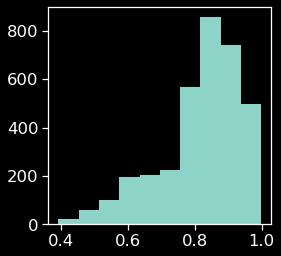

In [591]:
plt.rcParams["figure.figsize"] = (4,4)
plt.hist(df["Proportion members"])
plt.show()

In [592]:
def membership_level(item):
    if item < 0.7:
        return "low"
    if item >= 0.7 and item <= 0.8:
        return "medium"
    if item > 0.8:
        return "high"

In [593]:
df["membership"] = df["Proportion members"].apply(membership_level)

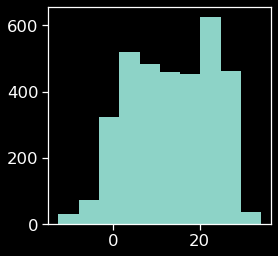

In [594]:
plt.hist(df["average Temp"])
plt.show()

In [595]:
def temperature_level(item):
    if item < 0:
        return "freezing"
    if item > 0 and item <= 15:
        return "cold"
    if item > 15:
        return "nice"

In [596]:
df["Temp Level"] = df["average Temp"].apply(temperature_level)

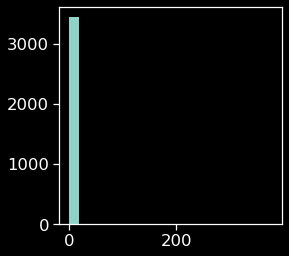

In [597]:
plt.hist(df["prcp"], bins=20)
plt.show()

In [598]:
def rain_level(item):
    if item <= 0:
        return "dry"
    if item > 0 and item < 1:
        return "light"
    if item >= 1:
        return "heavy"

In [599]:
df["Rain Level"] = df["prcp"].apply(rain_level)

In [600]:
def date_to_nth_day(date, format='%Y-%m-%d'):
    date = pd.to_datetime(date, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1

In [601]:
df["Day of year"] = df["Date"].apply(date_to_nth_day)

In [602]:
spring = range(80, 172)
summer = range(172, 264)
autumn = range(264, 355)

def season(item):
    if item in spring:
          return 'spring'
    elif item in summer:
          return 'summer'
    elif item in autumn:
          return 'autumn'
    else:
          return 'winter'

In [603]:
 df["Season"] = df["Day of year"].apply(season)

In [604]:
df.head() # data is ready for further analyses

Date  Total bicicle usage(seconds)  Number of trips  \
0 2010-09-20                      242253.0              212   
1 2010-09-21                      414304.0              324   
2 2010-09-22                      600602.0              377   
3 2010-09-23                      650596.0              373   
4 2010-09-24                      704149.0              362   

   Proportion members  Usage per bike(seconds)   Week day  prcp  t max  t min  \
0            0.839623                   1143.0     Monday   0.0   25.6   12.8   
1            0.663580                   1279.0    Tuesday   0.0   25.0    8.3   
2            0.689655                   1593.0  Wednesday   0.0   32.8   16.1   
3            0.667560                   1744.0   Thursday   0.0   31.7   17.8   
4            0.569061                   1945.0     Friday   0.0   35.0   21.1   

   average Temp  ...  Holiday/Weekend  Year  Month  Week  Day  membership  \
0         19.20  ...                0  2010      9    38   20        high   
1         16.65  ...                0  2010      9    38   21         low   
2         24.45  ...                0  2010      9    38   22         low   
3         24.75  ...                0  2010      9    38   23         low   
4         28.05  ...                0  2010      9    38   24         low   

  Temp Level Rain Level Day of year  Season  
0       nice        dry         263  summer  
1       nice        dry         264  autumn  
2       nice        dry         265  autumn  
3       nice        dry         266  autumn  
4       nice        dry         267  autumn  

[5 rows x 21 columns]

In [605]:
df.to_csv("df_bike_project.csv", index=False)

Run from here

In [869]:
df = pd.read_csv("df_bike_project.csv")

In [870]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

In [871]:
df.sort_values(by="Date", inplace=True)

In [872]:
df.reset_index(drop=True, inplace=True)

In [873]:
df.rename({"Total bicicle usage(seconds)":"Total usage(s)",
           "Number of trips": "N of trips",
           "Proportion members":"Prop members",
           "Usage per bike(seconds)": "Usage per trip(s)"}, axis=1, inplace=True)

### 2. Exploratory Data Analyses (EDA)

2.1 Looking for time **patterns** in our data. How bicicle usage has progressed over time? What seems to drive bicicle usage?

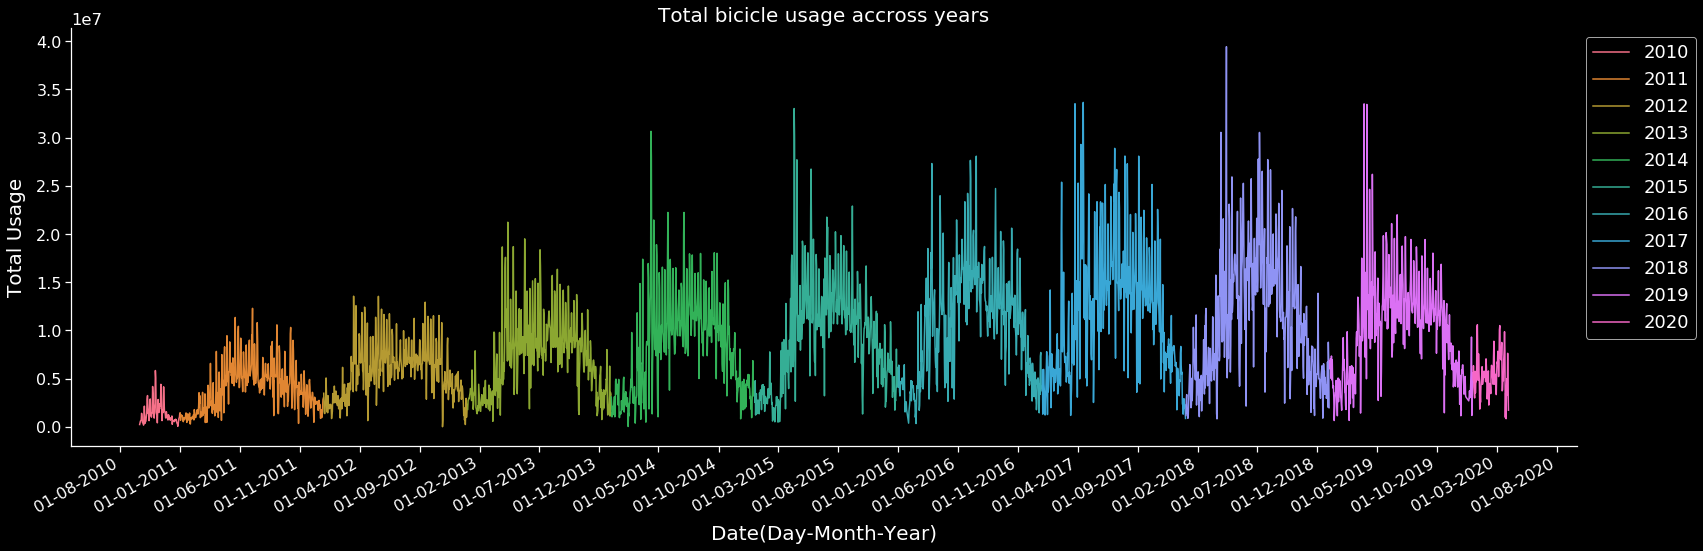

In [874]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Year", height=8, aspect=3)
g=g.map(plt.plot, "Date", "Total usage(s)")
plt.legend(scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Total bicicle usage accross years", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Total Usage", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

#plt.savefig("pattern_year.png", dpi=400)

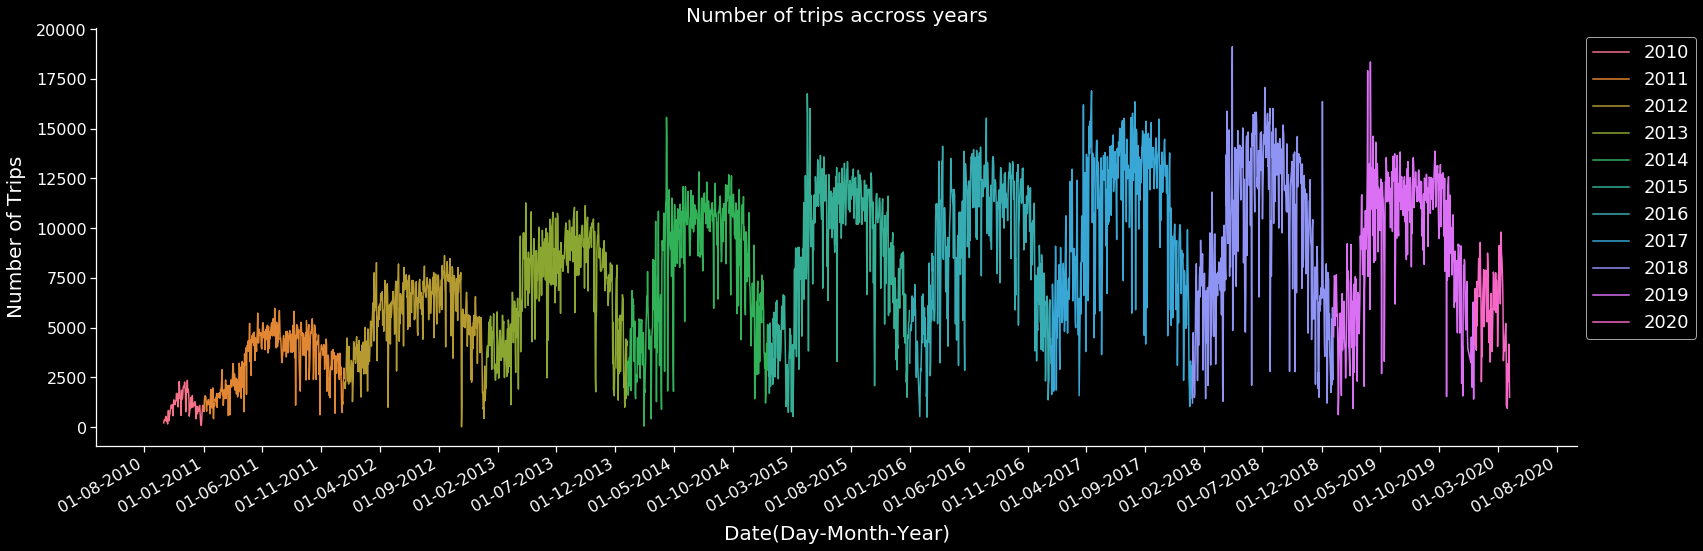

In [875]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Year", height=8, aspect=3)
g=g.map(plt.plot, "Date", "N of trips")
plt.legend(scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Number of trips accross years", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Number of Trips", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

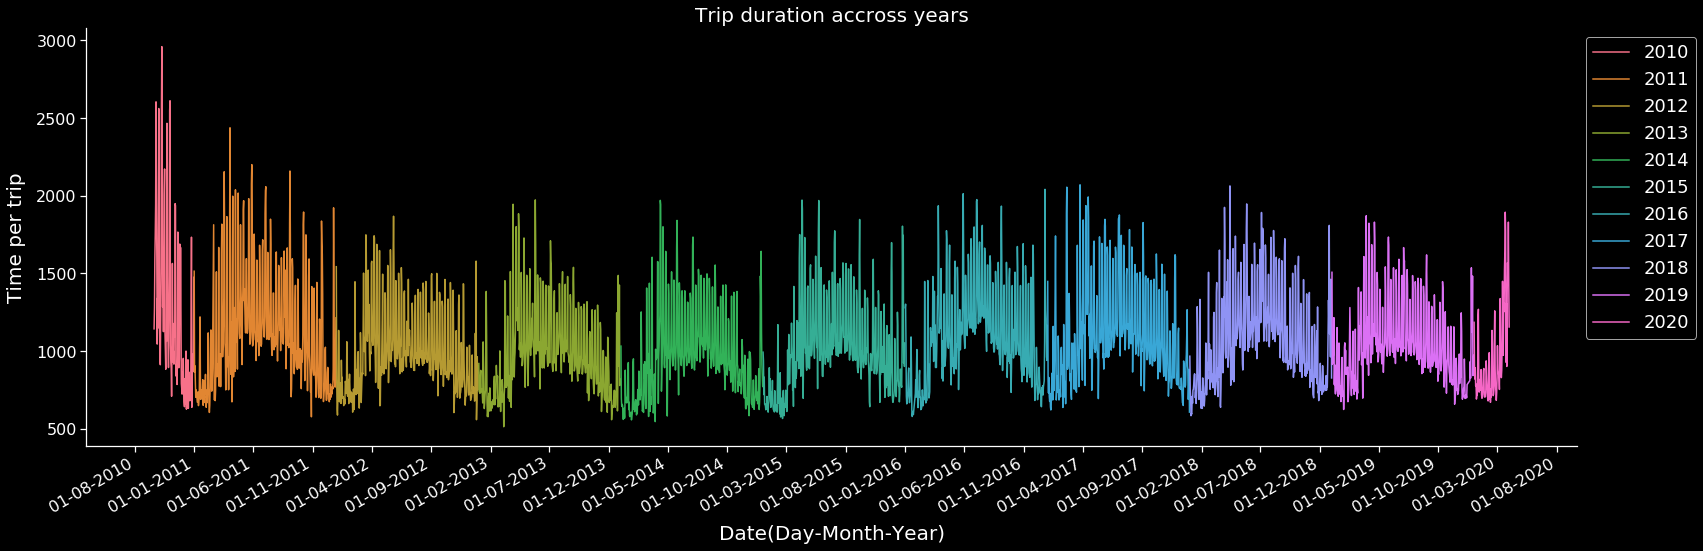

In [876]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Year", height=8, aspect=3)
g=g.map(plt.plot, "Date", "Usage per trip(s)")
plt.legend(scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Trip duration accross years", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Time per trip", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

In the graph above we can observe a pattern in the bicicle usage yearly consistent with the **weather seasons**. To make this more apparent we can draw a temperature line across. Furthermore, it is clear that during the first 7-8 years the company was growing, but in the last 3 years bicicle usage has stabilized.

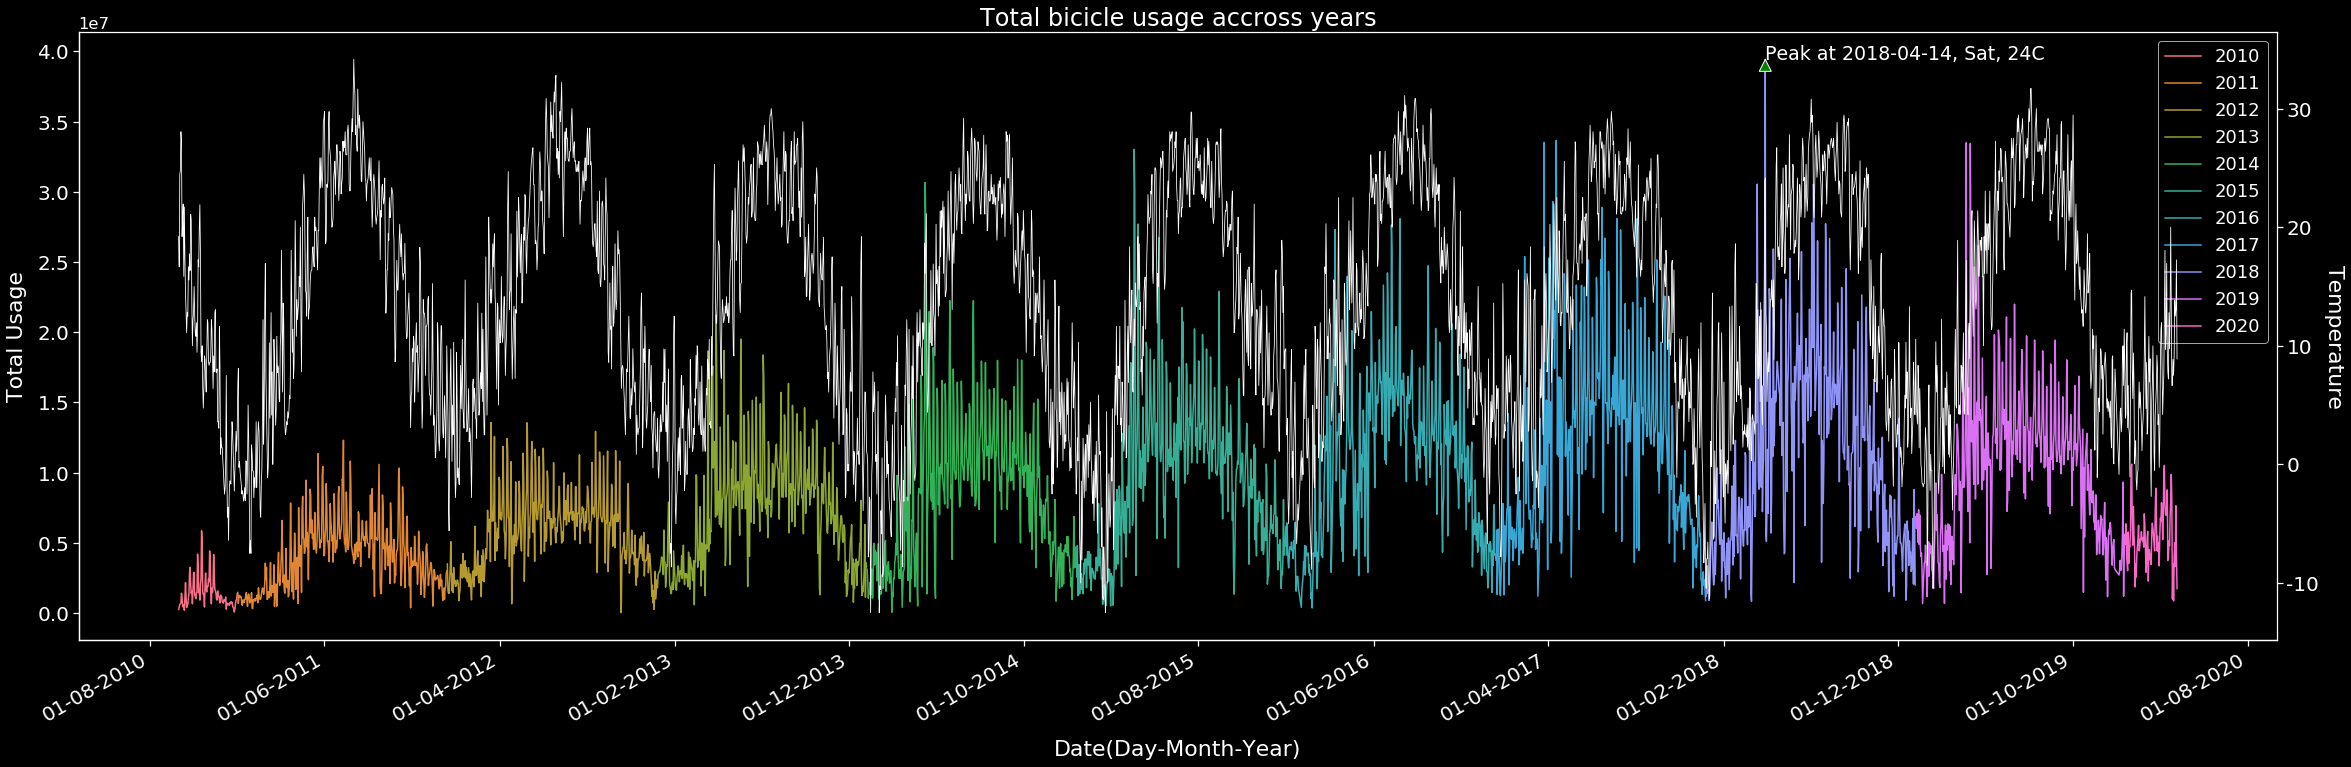

In [877]:
plt.style.use("dark_background")



plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Year", height=11, aspect=3)
g=g.map(plt.plot, "Date", "Total usage(s)")
plt.legend(loc= "best", fontsize=18,  ncol=1)
plt.title("Total bicicle usage accross years", fontsize=24)


xmax=df[df["Total usage(s)"] == (df["Total usage(s)"].max())]["Date"]
ymax=df["Total usage(s)"].max()
plt.annotate(s = "Peak at {}, Sat, 24C ".format((str(xmax.values[0])[:10])),xy=(xmax,ymax),xytext=(xmax, ymax+5),  size=19,
           arrowprops=dict(facecolor='green', width=0.02), xycoords="data")

plt.ylabel("Total Usage", labelpad=10, fontsize=22)
plt.xlabel("Date(Day-Month-Year)", labelpad=15, fontsize=22)
plt.xticks(rotation="30", fontsize=20)
plt.yticks(rotation="horizontal", fontsize=20)

ax2 = plt.twinx() 
ax2.plot(df["Date"],df["average Temp"], "w-", linewidth=0.8)
ax2.set_ylabel('Temperature', rotation=270, labelpad=25, fontsize=22)
ax2.set_yticklabels([-20,-10, 0, 10, 20, 30],fontsize=20)

plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=10))


plt.tight_layout()

#plt.savefig("pattern_year_temperature.png", dpi=400)

We also observe a **clear drop** in bicycle usage after the coronavirus pandemia started. Since this is a very unusual event and a source of outliers, from here on I will only include the data before 2020.

In [878]:
df = df.loc[df["Date"] <= "2019-12-31"]

2.2 Lets also investigate whether if there is a pattern every **month** or **week**

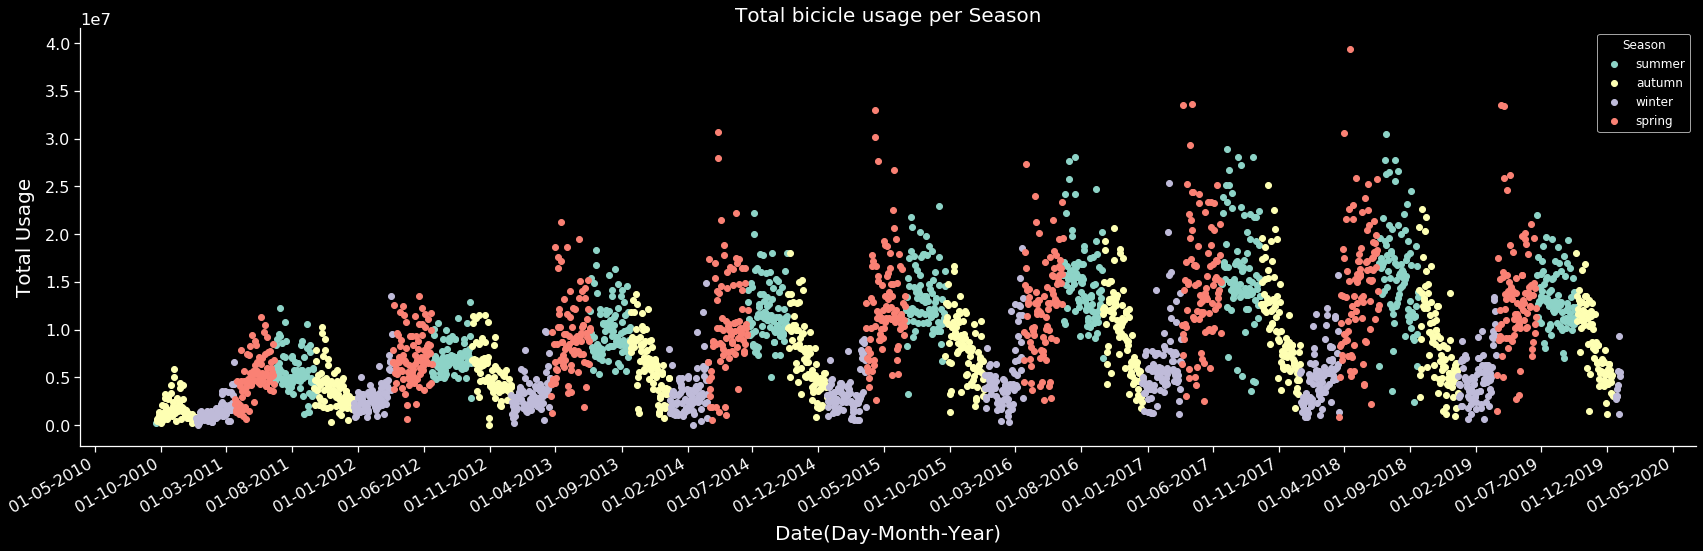

In [747]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Season", height=8, aspect=3)
g=g.map(plt.scatter, "Date", "Total usage(s)")
plt.legend(title="Season", scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=12,  ncol=1)
plt.title("Total bicicle usage per Season", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Total Usage", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

# plt.savefig("Bike_usage_season.png", dpi=400)

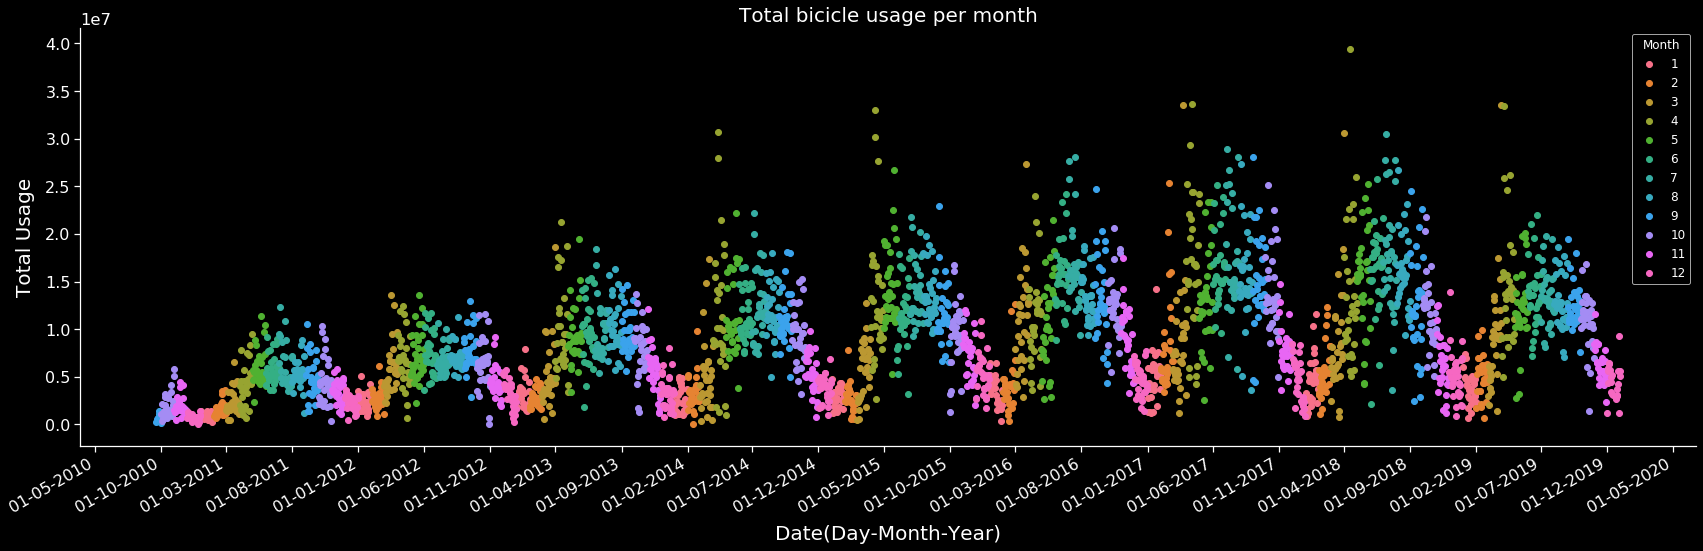

In [748]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Month", height=8, aspect=3)
g=g.map(plt.scatter, "Date", "Total usage(s)")
plt.legend(title="Month", scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=12,  ncol=1)
plt.title("Total bicicle usage per month", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Total Usage", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

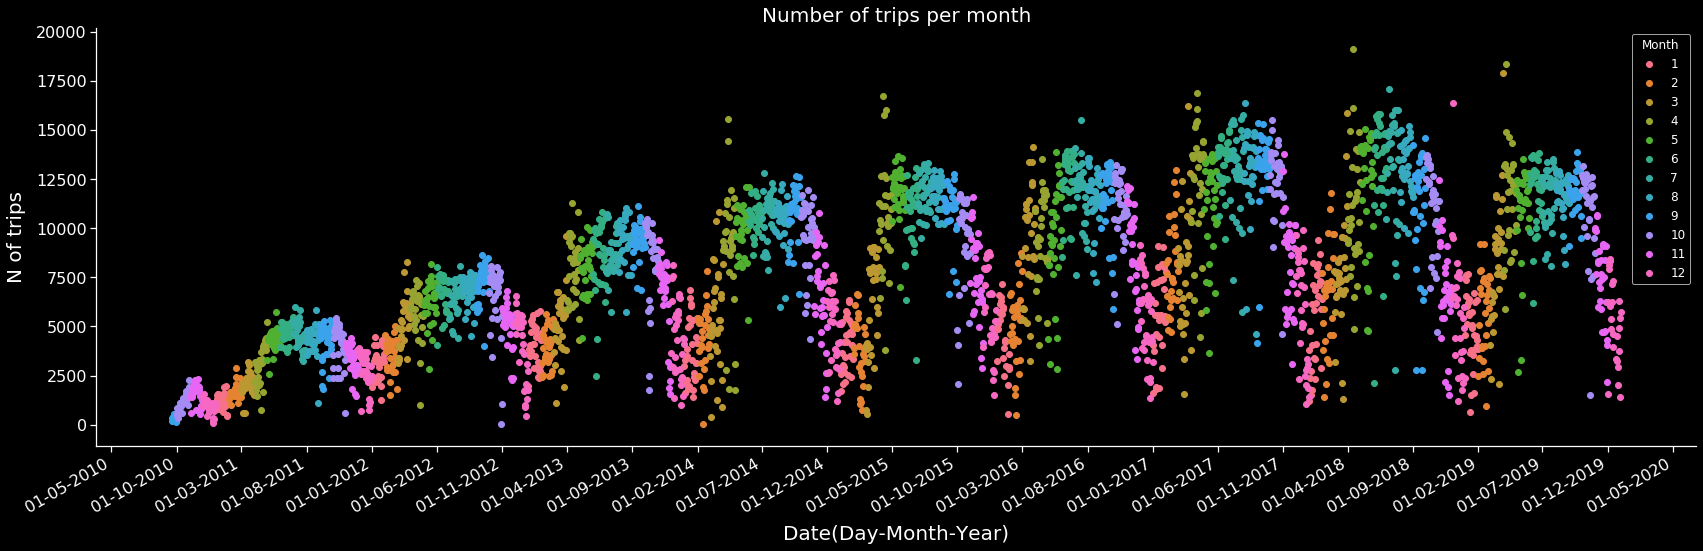

In [749]:
plt.style.use("dark_background")
g=sns.FacetGrid(df, hue="Month", height=8, aspect=3)
g=g.map(plt.scatter, "Date", "N of trips")
plt.legend(title="Month", scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=12,  ncol=1)
plt.title("Number of trips per month", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("N of trips", labelpad=10, fontsize=20)
plt.xlabel("Date(Day-Month-Year)", labelpad=10, fontsize=20)
plt.xticks(rotation="30", fontsize=16)
plt.yticks(rotation="horizontal", fontsize=16)

plt.tight_layout()

2.3 Effect of the **week day** on the bicicle usage

In [750]:
df_weeks = pd.pivot_table(df, index=["Week","Week day"], values = ["Total usage(s)","N of trips"], aggfunc = ["mean"]) # creating a pivot table to plot data averaged from all 10 years

In [751]:
df_weeks.reset_index(inplace=True)

In [752]:
df_weeks.columns = ["Week number", "Week day", "N of trips", "Total usage(s)"]

In [753]:
df_weeks

Week number   Week day   N of trips  Total usage(s)
0              1     Friday  4237.222222    3.345172e+06
1              1     Monday  3125.100000    2.662908e+06
2              1   Saturday  2955.444444    2.572762e+06
3              1     Sunday  3229.444444    2.902737e+06
4              1   Thursday  4148.888889    3.190192e+06
..           ...        ...          ...             ...
366           53   Saturday  4921.000000    6.405129e+06
367           53     Sunday  4965.000000    5.215354e+06
368           53   Thursday  5855.000000    6.153002e+06
369           53    Tuesday  5253.000000    5.210278e+06
370           53  Wednesday  5275.000000    4.755277e+06

[371 rows x 4 columns]

In [754]:
def week_day_order(item):
    if item == "Monday":
        return 1
    elif item == "Tuesday":
        return 2
    elif item == "Wednesday":
        return 3
    elif item == "Thursday":
        return 4
    elif item == "Friday":
        return 5
    elif item == "Saturday":
        return 6
    elif item == "Sunday":
        return 7

In [755]:
def num_week_to_season(item):
    if item <=8 or item >= 48:
        return "Winter"
    elif item > 8 and item <= 21:
        return "Spring"
    elif item > 21 and item <= 34:
        return "Summer"
    elif item > 34 and item < 48:
        return "Autumn"

In [756]:
df_weeks["Week day order"] = df_weeks["Week day"].apply(week_day_order) 

In [757]:
df_weeks["Season"] = df_weeks["Week number"].apply(num_week_to_season) 

In [758]:
df_weeks = df_weeks. sort_values(by=["Week number", "Week day order"])

In [759]:
df_weeks

Week number   Week day   N of trips  Total usage(s)  Week day order  \
1              1     Monday  3125.100000    2.662908e+06               1   
5              1    Tuesday  3770.600000    3.328210e+06               2   
6              1  Wednesday  4337.000000    3.415853e+06               3   
4              1   Thursday  4148.888889    3.190192e+06               4   
0              1     Friday  4237.222222    3.345172e+06               5   
..           ...        ...          ...             ...             ...   
370           53  Wednesday  5275.000000    4.755277e+06               3   
368           53   Thursday  5855.000000    6.153002e+06               4   
364           53     Friday  3220.000000    4.119373e+06               5   
366           53   Saturday  4921.000000    6.405129e+06               6   
367           53     Sunday  4965.000000    5.215354e+06               7   

     Season  
1    Winter  
5    Winter  
6    Winter  
4    Winter  
0    Winter  
..      ...  
370  Winter  
368  Winter  
364  Winter  
366  Winter  
367  Winter  

[371 rows x 6 columns]

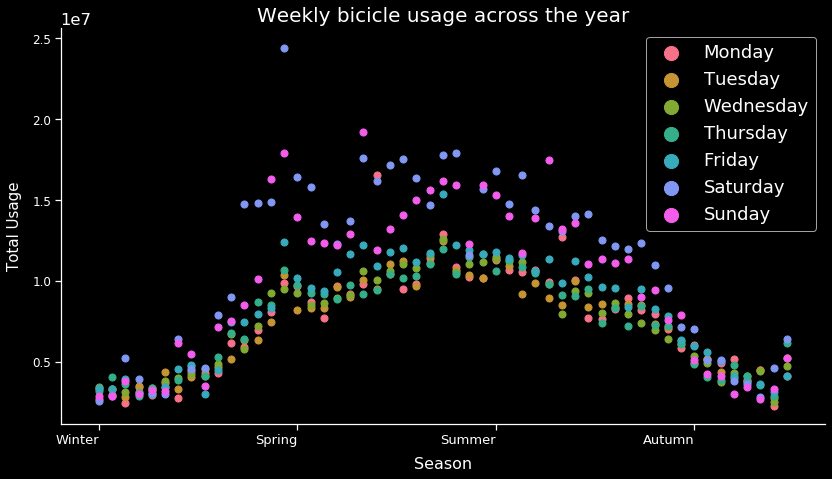

In [760]:
plt.style.use("dark_background")

# color=cm.rainbow(np.linspace(0,1,7))
week_pallete = sns.color_palette("husl", 7)

g=sns.FacetGrid(df_weeks, hue="Week day", height=7, aspect=1.7, palette=week_pallete)




g=g.map(plt.scatter, "Week number", "Total usage(s)", s=50, alpha=1)
plt.legend(markerscale=2, scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Weekly bicicle usage across the year", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("Total Usage", labelpad=10, fontsize=15)
plt.xlabel("Season", labelpad=10, fontsize=16)
plt.xticks(np.arange(1,53, step=15), list(df_weeks["Season"].unique()), rotation=0, fontsize=13)
plt.yticks(rotation="horizontal", fontsize=12)

plt.tight_layout()

#plt.savefig("Weekly_bike_usage_year.png", dpi=400)

We can clearly see that during weekend speople use bike more time specially during the spring and summer seasons

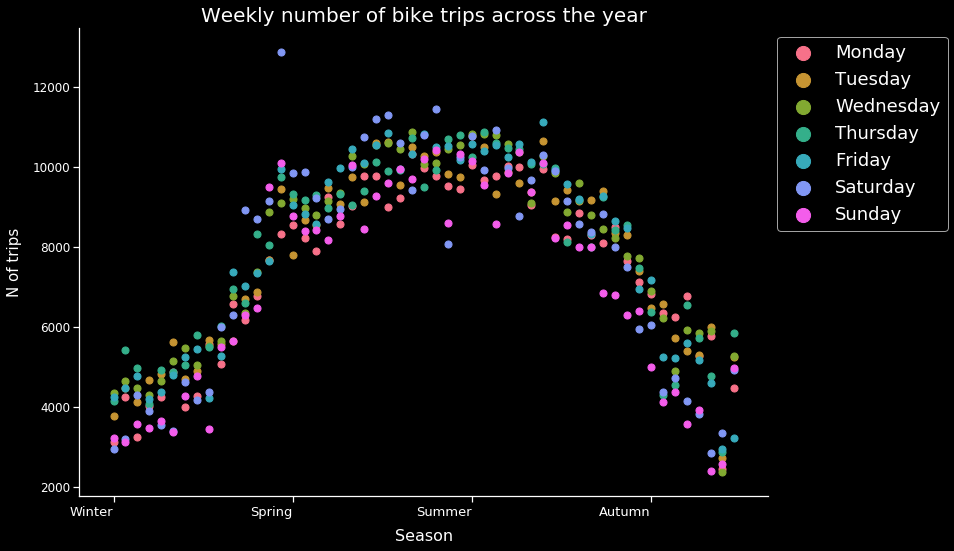

In [761]:
plt.style.use("dark_background")

# color=cm.rainbow(np.linspace(0,1,7))
week_pallete = sns.color_palette("husl", 7)

g=sns.FacetGrid(df_weeks, hue="Week day", height=8, aspect=1.7, palette=week_pallete)




g=g.map(plt.scatter, "Week number", "N of trips", s=50, alpha=1)
plt.legend(markerscale=2, scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Weekly number of bike trips across the year", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("N of trips", labelpad=10, fontsize=15)
plt.xlabel("Season", labelpad=10, fontsize=16)
plt.xticks(np.arange(1,53, step=15), list(df_weeks["Season"].unique()), rotation=0, fontsize=13)
plt.yticks(rotation="horizontal", fontsize=12)

plt.tight_layout()

#plt.savefig("Weekly_number_trips_year.png", dpi=400)

In [762]:
df_weeks["Usage per trip(s)"] = df_weeks["Total usage(s)"]/df_weeks["N of trips"]

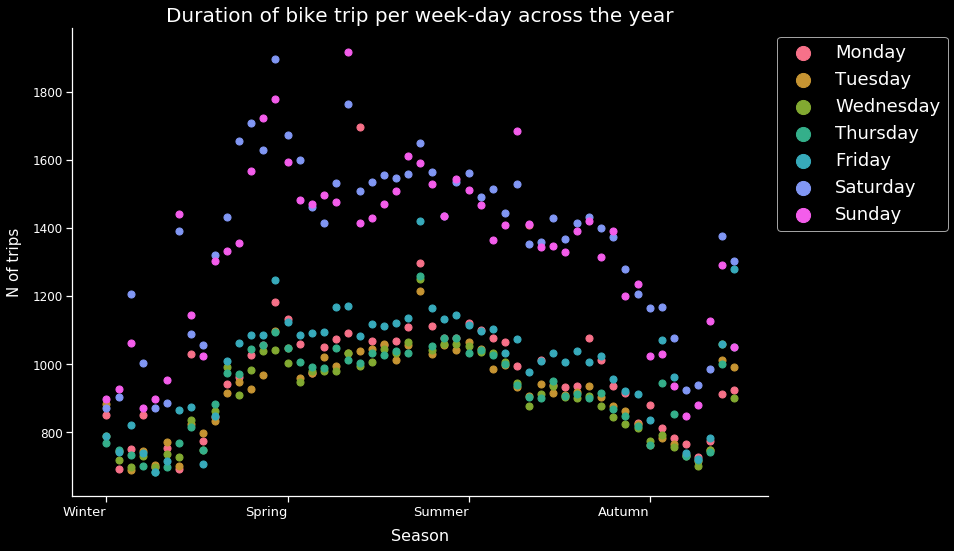

In [763]:
plt.style.use("dark_background")

# color=cm.rainbow(np.linspace(0,1,7))
week_pallete = sns.color_palette("husl", 7)

g=sns.FacetGrid(df_weeks, hue="Week day", height=8, aspect=1.7, palette=week_pallete)
g=g.map(plt.scatter, "Week number", "Usage per trip(s)", s=50, alpha=1)

plt.legend(markerscale=2, scatterpoints=1, bbox_to_anchor=(1, 1), loc= "best", fontsize=18,  ncol=1)
plt.title("Duration of bike trip per week-day across the year", fontsize=20)


plt.gcf().autofmt_xdate() # gcf (get current figure)
date_format = mpl_dates.DateFormatter("%d-%m-%Y")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mpl_dates.MonthLocator(interval=5))


plt.ylabel("N of trips", labelpad=10, fontsize=15)
plt.xlabel("Season", labelpad=10, fontsize=16)
plt.xticks(np.arange(1,53, step=15), list(df_weeks["Season"].unique()), rotation=0, fontsize=13)
plt.yticks(rotation="horizontal", fontsize=12)

plt.tight_layout()

#plt.savefig("Duration_trips_year.png", dpi=400)

In the plot above we again observe that number of trips increase clearly during **spring and summer**, but the differences among week days are not so large as compared to the total trip time. This indicates that on these months the number of trips is similar along the week, but people use the bikes longer time during weekends.

2.3 Lets analyze now if temperature, rain and membership have a major effects on the total time per trip and on the total number of trips.

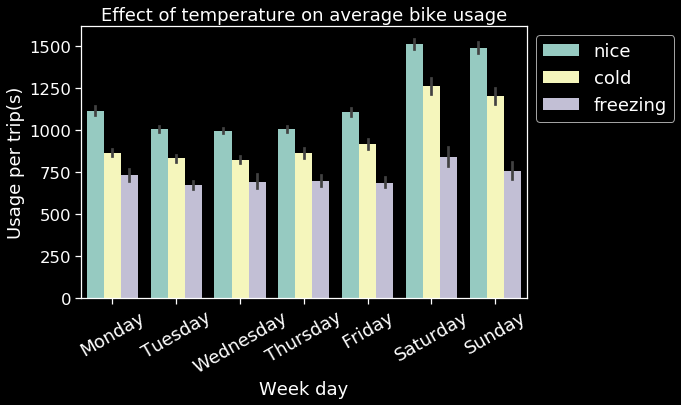

In [764]:
plt.subplots(figsize=(8,5))
plt.title("Effect of temperature on average bike usage")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="Usage per trip(s)", data=df, hue="Temp Level")
plt.legend(bbox_to_anchor=(1.35, 1), loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
#plt.savefig("Effect of temperature on bike usage.png", dpi=400)
plt.show()

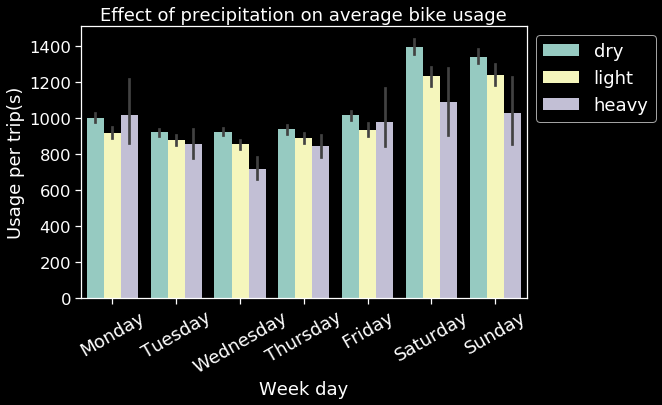

In [765]:
plt.subplots(figsize=(8,5))
plt.title("Effect of precipitation on average bike usage")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="Usage per trip(s)", data=df, hue="Rain Level")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

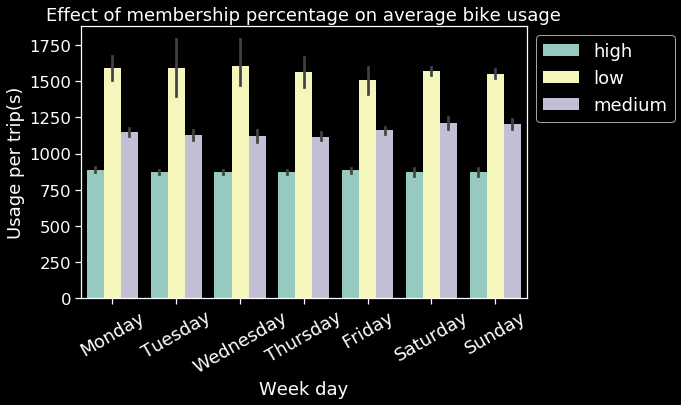

In [766]:
plt.subplots(figsize=(8,5))
plt.title("Effect of membership percentage on average bike usage")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="Usage per trip(s)", data=df, hue="membership")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

From the above plots we observe that temperature seems to be a higher factor compared to rain in the average time per trip. This could be because when it rains people tend to take the bike less(we can actually see this is the case in the plot below). We also see that when its freezing, there is not increase in the average time of usage over the weekend.
Furthermore, we observe that the higher the membership percentage, the lower the ride time.

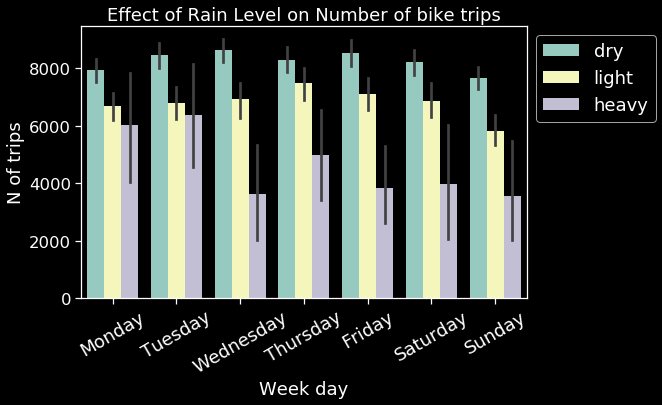

In [767]:
plt.subplots(figsize=(8,5))
plt.title("Effect of Rain Level on Number of bike trips")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="N of trips", data=df, hue="Rain Level")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

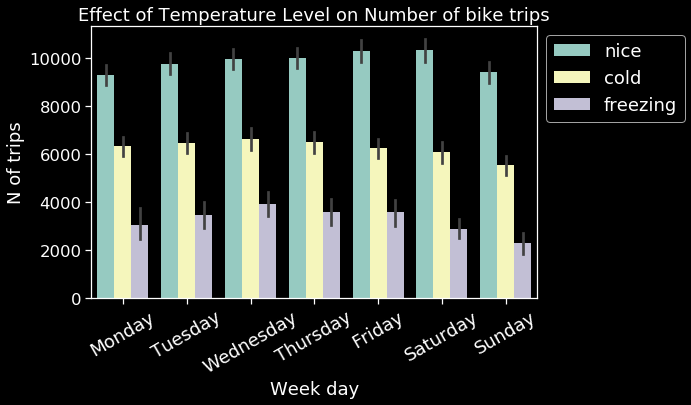

In [768]:
plt.subplots(figsize=(8,5))
plt.title("Effect of Temperature Level on Number of bike trips")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="N of trips", data=df, hue="Temp Level")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

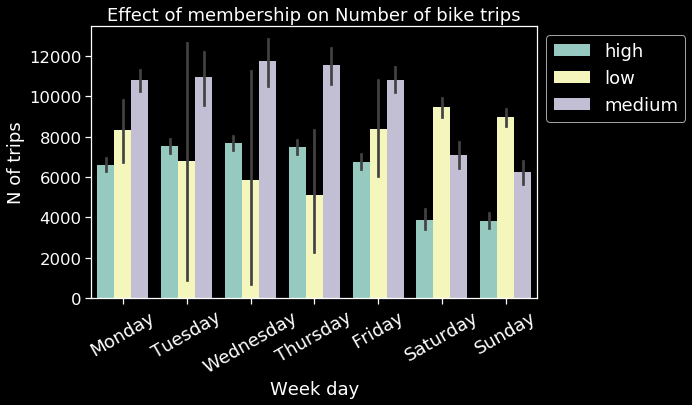

In [769]:
plt.subplots(figsize=(8,5))
plt.title("Effect of membership on Number of bike trips")
sns.set_context("notebook", font_scale=1.5)
sns.barplot(x="Week day", y="N of trips", data=df, hue="membership")
plt.legend(bbox_to_anchor=(1, 1),loc= "best", fontsize=18,  ncol=1)
plt.xticks(rotation="30", fontsize=18)
plt.show()

2.4 Next, let's investigate the correlation among the attributes paying special attention to the correlation with the total usage and number of trips

In [770]:
df.head()

Date  Total usage(s)  N of trips  Prop members  Usage per trip(s)  \
0 2010-09-20        242253.0         212      0.839623             1143.0   
1 2010-09-21        414304.0         324      0.663580             1279.0   
2 2010-09-22        600602.0         377      0.689655             1593.0   
3 2010-09-23        650596.0         373      0.667560             1744.0   
4 2010-09-24        704149.0         362      0.569061             1945.0   

    Week day  prcp  t max  t min  average Temp  ...  Holiday/Weekend  Year  \
0     Monday   0.0   25.6   12.8         19.20  ...                0  2010   
1    Tuesday   0.0   25.0    8.3         16.65  ...                0  2010   
2  Wednesday   0.0   32.8   16.1         24.45  ...                0  2010   
3   Thursday   0.0   31.7   17.8         24.75  ...                0  2010   
4     Friday   0.0   35.0   21.1         28.05  ...                0  2010   

   Month  Week  Day  membership Temp Level Rain Level Day of year  Season  
0      9    38   20        high       nice        dry         263  summer  
1      9    38   21         low       nice        dry         264  autumn  
2      9    38   22         low       nice        dry         265  autumn  
3      9    38   23         low       nice        dry         266  autumn  
4      9    38   24         low       nice        dry         267  autumn  

[5 rows x 21 columns]

In [771]:
df_corr = df.iloc[:, [1,2,3,4,6,7,8,9,17]]

In [772]:
df_corr

Total usage(s)  N of trips  Prop members  Usage per trip(s)  prcp  \
0           242253.0         212      0.839623             1143.0  0.00   
1           414304.0         324      0.663580             1279.0  0.00   
2           600602.0         377      0.689655             1593.0  0.00   
3           650596.0         373      0.667560             1744.0  0.00   
4           704149.0         362      0.569061             1945.0  0.00   
...              ...         ...           ...                ...   ...   
3375       5661495.0        4916      0.808991             1152.0  0.00   
3376       9316967.0        6282      0.724292             1483.0  0.00   
3377       1186277.0        1409      0.850248              842.0  0.59   
3378       5117779.0        5419      0.866396              944.0  0.24   
3379       5583152.0        5746      0.886878              972.0  0.00   

      t max  t min  average Temp Temp Level  
0      25.6   12.8         19.20       nice  
1      25.0    8.3         16.65       nice  
2      32.8   16.1         24.45       nice  
3      31.7   17.8         24.75       nice  
4      35.0   21.1         28.05       nice  
...     ...    ...           ...        ...  
3375   14.4    5.0          9.70       cold  
3376   18.3    1.7         10.00       cold  
3377    8.9    4.4          6.65       cold  
3378   16.7    6.1         11.40       cold  
3379   11.7    5.6          8.65       cold  

[3380 rows x 9 columns]

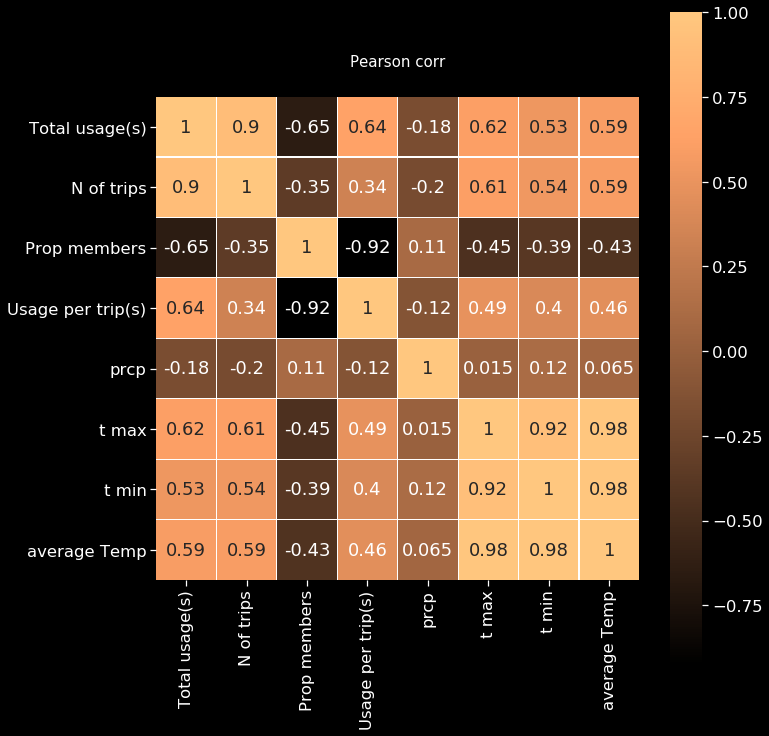

In [773]:
plt.rcParams["figure.figsize"] = (11,11)
colormap=plt.cm.copper
plt.title("Pearson corr", y=1.05, size=15)
sns.heatmap(df_corr.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)
plt.tight_layout()
# plt.savefig("corr.png", dpi=400)
plt.show()

In [774]:
corr_matrix = df_corr.corr()


In [775]:
corr_matrix

Total usage(s)  N of trips  Prop members  \
Total usage(s)           1.000000    0.901450     -0.648636   
N of trips               0.901450    1.000000     -0.349149   
Prop members            -0.648636   -0.349149      1.000000   
Usage per trip(s)        0.643249    0.337494     -0.924227   
prcp                    -0.176296   -0.196067      0.105126   
t max                    0.615699    0.613120     -0.451857   
t min                    0.533950    0.538986     -0.388441   
average Temp             0.587839    0.588958     -0.429727   

                   Usage per trip(s)      prcp     t max     t min  \
Total usage(s)              0.643249 -0.176296  0.615699  0.533950   
N of trips                  0.337494 -0.196067  0.613120  0.538986   
Prop members               -0.924227  0.105126 -0.451857 -0.388441   
Usage per trip(s)           1.000000 -0.119251  0.488142  0.403228   
prcp                       -0.119251  1.000000  0.014729  0.116195   
t max                       0.488142  0.014729  1.000000  0.921772   
t min                       0.403228  0.116195  0.921772  1.000000   
average Temp                0.456157  0.064984  0.981608  0.978839   

                   average Temp  
Total usage(s)         0.587839  
N of trips             0.588958  
Prop members          -0.429727  
Usage per trip(s)      0.456157  
prcp                   0.064984  
t max                  0.981608  
t min                  0.978839  
average Temp           1.000000

In [776]:
corr_vals = abs(corr_matrix[["Total usage(s)", "N of trips"]]).sort_values(by=["Total usage(s)", "N of trips"], ascending=False)

In [777]:
corr_vals

Total usage(s)  N of trips
Total usage(s)           1.000000    0.901450
N of trips               0.901450    1.000000
Prop members             0.648636    0.349149
Usage per trip(s)        0.643249    0.337494
t max                    0.615699    0.613120
average Temp             0.587839    0.588958
t min                    0.533950    0.538986
prcp                     0.176296    0.196067

Lets explore the relactionships between these variables and their distributions with pair-density plots

In [778]:
df_corr_pair = df_corr.drop(["t max", "t min"], axis=1)

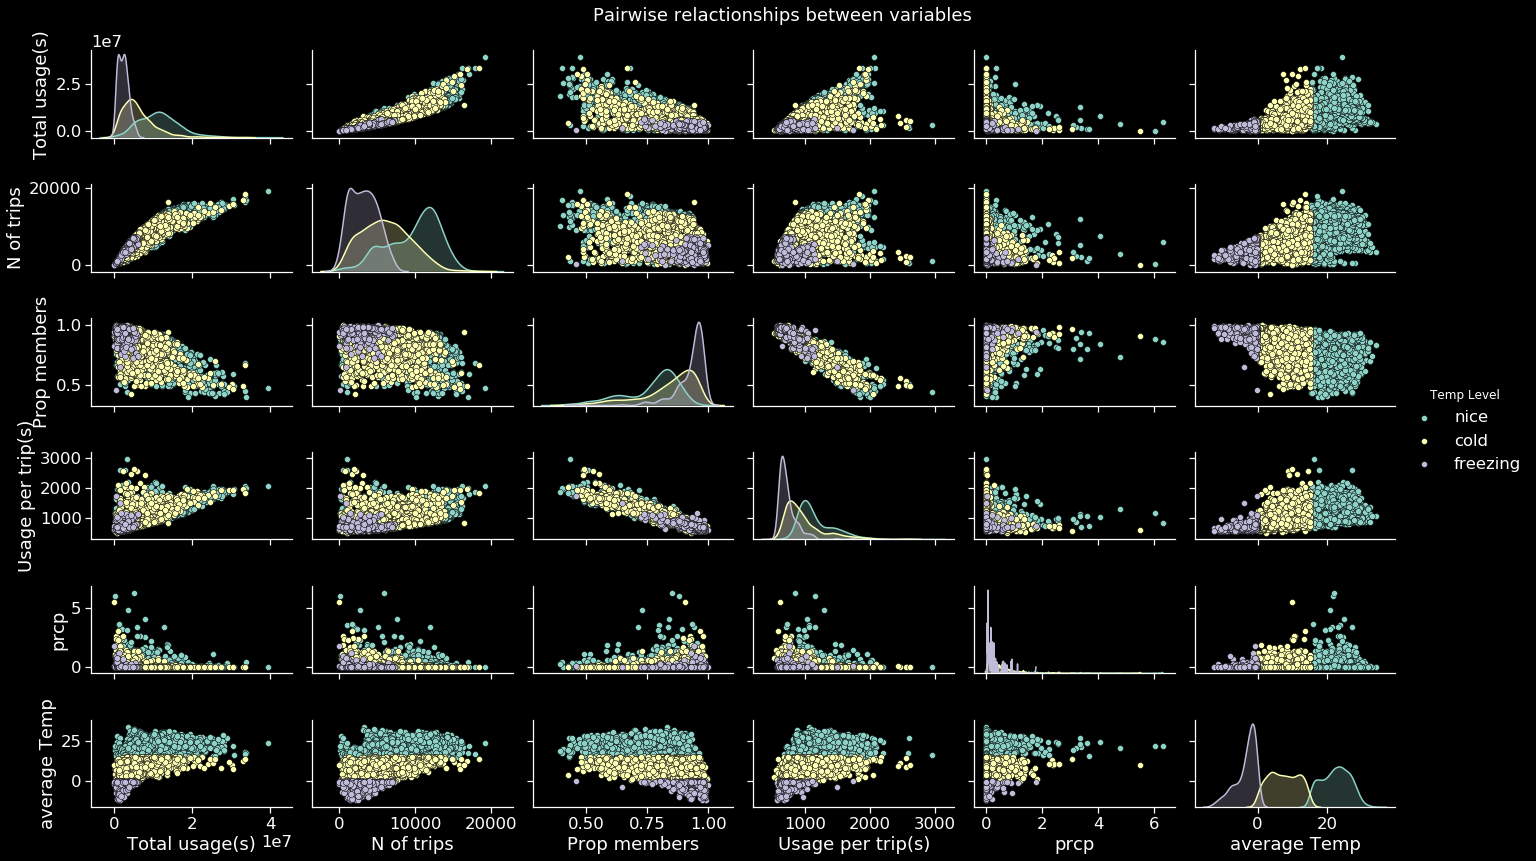

In [897]:
g = sns.pairplot(data=df_corr_pair,hue="Temp Level",size=2, aspect=1.6,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = g.fig  
fig.subplots_adjust(top=0.93, wspace=0.1)
t = fig.suptitle('Pairwise relactionships between variables', fontsize=18)
#fig.savefig("Pair-kde.png", dpi=400, bbox_inches="tight")
plt.show()


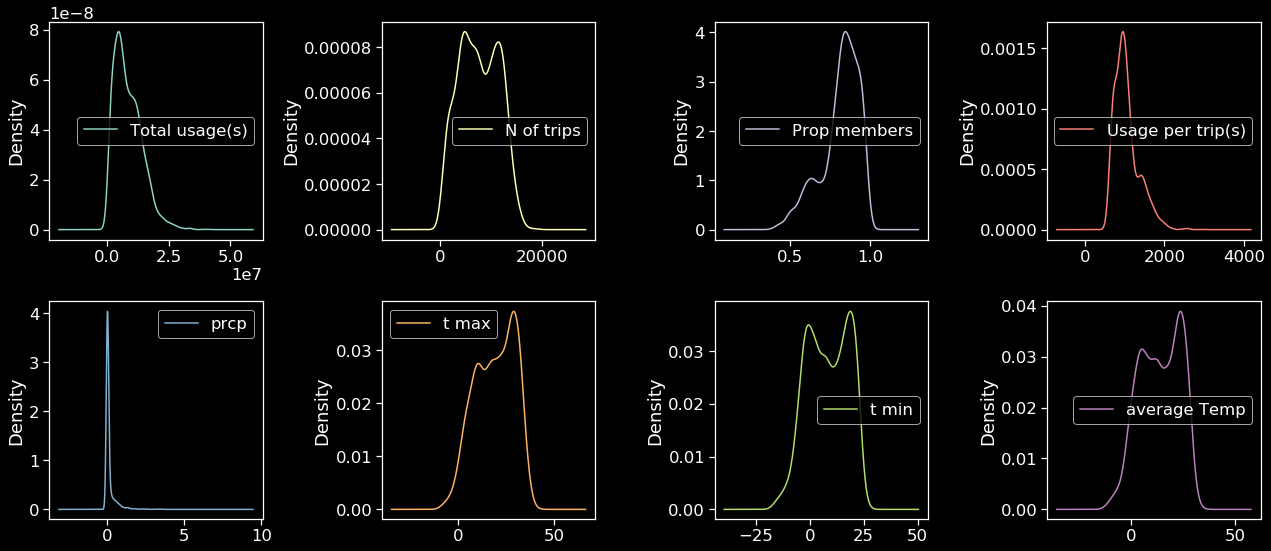

In [896]:
df_corr.plot(kind='kde', subplots=True, layout=(2,4), sharex=False,figsize=(18,8))
plt.tight_layout()
#plt.savefig("density numeric attributes.png", dpi=400, bbox_inches="tight")

### 3. Prepare data for modeling (Preprocessing)

First we need to choose the attributes for the modeling.
* Numerical
    * Proportion members
    * t max
    * prcp	
* Categorical variables
    * holidays
    * dates: Dates are rich sources of information. We saw that the week day and year-period reflect bicicle usage patterns. 

In [781]:
df.columns

Index(['Date', 'Total usage(s)', 'N of trips', 'Prop members',
       'Usage per trip(s)', 'Week day', 'prcp', 't max', 't min',
       'average Temp', 'Holiday', 'Holiday/Weekend', 'Year', 'Month', 'Week',
       'Day', 'membership', 'Temp Level', 'Rain Level', 'Day of year',
       'Season'],
      dtype='object')

In [782]:
df_model = df[['Total usage(s)', 'N of trips', "prcp", "t max", "t min", "Year", "Month", "Holiday", "Week day"]]

In [783]:
df_model = pd.get_dummies(df_model)

In [784]:
df_model.columns = df_model.columns.str.replace("Week day_", "")

### 4. Data Split

We want that after our split we obtian a balanced distribution of the target values accorss the data. Hence, we first need to see whether if our target **normaly distributed** or **skewed**? We will start predicting the Total Usage. We observe that the data is skewed to the right. Hence, stratifying the data set is adviced for the splitting.

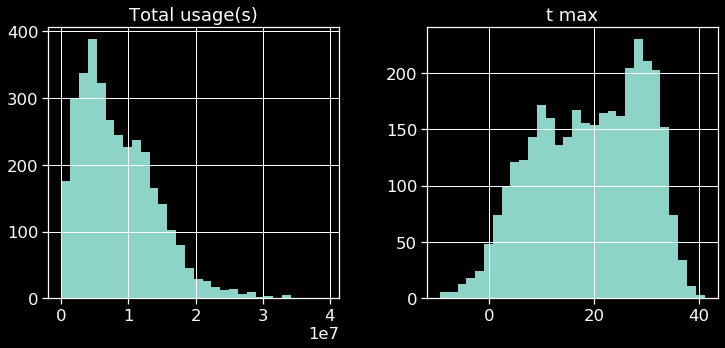

In [785]:
plt.rcParams["figure.figsize"] = (12,5)
df_model[['Total usage(s)','t max']].hist(bins=30)
plt.show()

Lets stratify the split based on the stratification of t max in 5 different strata.

In [786]:
def strater (col_item):
    if col_item <= 5:
        return 1
    elif col_item > 5 and col_item <= 12:
        return 2
    elif col_item > 12 and col_item <= 23:
        return 3
    elif col_item > 23 and col_item <= 30:
        return 4
    else:
        return 5

In [787]:
df_model["strat"] = df_model["t max"].apply(strater)

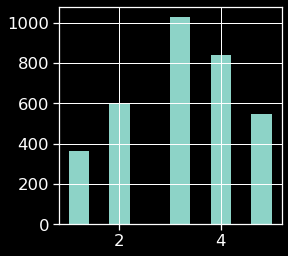

In [788]:
plt.rcParams["figure.figsize"] = (4,4)
df_model["strat"].hist(bins=10)
plt.show()

In [789]:
X = df_model.drop(['Total usage(s)','N of trips'], axis=1)
y = df_model['Total usage(s)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [790]:
test_set = X_test

In [791]:
test_set["strat"] = X_test["t max"].apply(strater)

In [792]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=10)

In [793]:
for train_index, test_index in split.split(df_model, df_model["strat"]):
    strat_train_set = df_model.loc[train_index]
    strat_test_set = df_model.loc[test_index]

In [794]:
def proportions(data):
    return data["strat"].value_counts()/len(data)

In [795]:
comparing = pd.DataFrame({"Overall": proportions(df_model),
                         "Stratified": proportions(strat_test_set),
                         "Random": proportions(X_test)}).sort_index()

In [796]:
comparing = round(comparing *100,2) 

In [797]:
comparing 
# We can observe how the proportions in the stratified set are closer 
# to those in the whole set compared to the ramdomly generated set

Overall  Stratified  Random
1    10.80       10.80   10.21
2    17.69       17.60   17.31
3    30.41       30.47   29.44
4    24.88       24.85   25.59
5    16.21       16.27   17.46

In [798]:
strat_train_set.drop("strat", axis=1, inplace=True)
strat_test_set.drop("strat", axis=1, inplace=True)

In [799]:
X_train = strat_train_set.drop(["Total usage(s)","N of trips"], axis=1)
y_train = strat_train_set["Total usage(s)"].values

In [800]:
X_test = strat_test_set.drop(["Total usage(s)","N of trips"], axis=1)
y_test = strat_test_set["Total usage(s)"].values

In [801]:
df_model.drop("strat", axis=1, inplace=True)
X.drop("strat", axis=1, inplace=True)

### 5. Data standarization

In [802]:
scaler = StandardScaler().fit(X) # Scaling the data
X_rescaled = scaler.transform(X)

In [803]:
df_rescaled=pd.DataFrame(X_rescaled)
df_rescaled.columns = X.columns

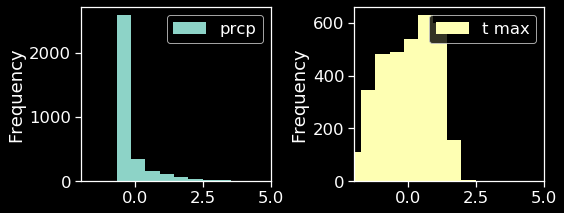

In [804]:

df_rescaled.iloc[:,:2].plot(kind='hist', bins=35, subplots=True, layout=(2,2), sharex=False,figsize=(8,6), xlim=(-2,5))

plt.tight_layout()
#plt.savefig("density numeric attributes.png", dpi=400)

In [805]:
X_rescaled.shape

(3380, 13)

Lets use some PCA to observe what are the features driving the variance in our train set

In [806]:
# PCA
pca = PCA(n_components = 3)
X3D = pca.fit_transform(X_rescaled)

In [807]:
sum(pca.explained_variance_ratio_) # Three components only account for 39% of the variance

0.3507878264758096

In [808]:
X_red = pd.DataFrame(X3D)

In [809]:
X_red

0         1         2
0    -0.810353  2.079718 -0.475731
1    -0.591287 -0.339868  1.749458
2    -1.613719 -0.308889 -0.660172
3    -1.654974  0.105867  0.804178
4    -2.022613 -0.210631 -0.853370
...        ...       ...       ...
3375  0.121799 -0.285019 -0.747302
3376  0.130370 -0.610854 -0.193274
3377  0.380091 -0.679245 -1.247132
3378 -0.152179  2.040875 -0.291243
3379  0.128131 -0.374413  1.798185

[3380 rows x 3 columns]

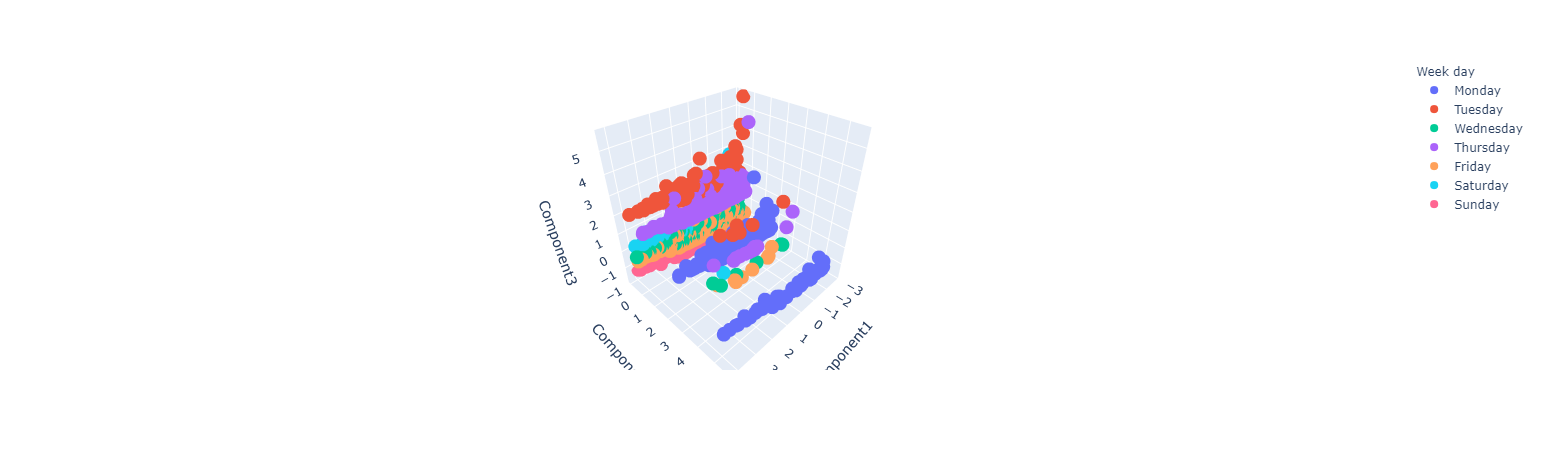

In [810]:


week_day_pca = pd.concat([X_red,pd.DataFrame(df["Week day"], columns=["Week day"])], axis=1)
week_day_pca.columns = ["Component1", "Component2", "Component3", "Week day"]

fig = px.scatter_3d(week_day_pca, x='Component1', y='Component2', z='Component3',
              color='Week day')

fig.show()

In [811]:
# PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X_rescaled)
X_red = pd.DataFrame(X2D)

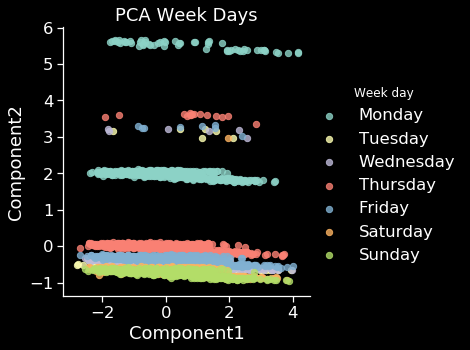

In [812]:
week_day_pca = pd.concat([X_red,pd.DataFrame(df["Week day"], columns=["Week day"])], axis=1)
week_day_pca.columns = ["Component1", "Component2", "Week day"]
grid = sns.FacetGrid(week_day_pca, height=5, hue="Week day")
grid.map(plt.scatter, "Component1", "Component2", s=40, alpha=0.8).add_legend()
plt.title("PCA Week Days")
plt.show()

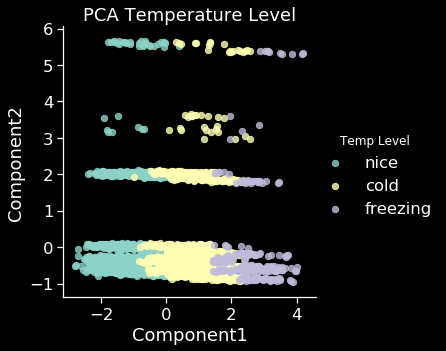

In [813]:
temp_level_pca = pd.concat([X_red,pd.DataFrame(df["Temp Level"], columns=["Temp Level"])], axis=1)
temp_level_pca.columns = ["Component1", "Component2", "Temp Level"]
grid = sns.FacetGrid(temp_level_pca, height=5, hue="Temp Level")
grid.map(plt.scatter, "Component1", "Component2", s=40, alpha=0.8).add_legend()
plt.title("PCA Temperature Level")
#plt.savefig("Temp_level.png", dpi=400)
plt.show()

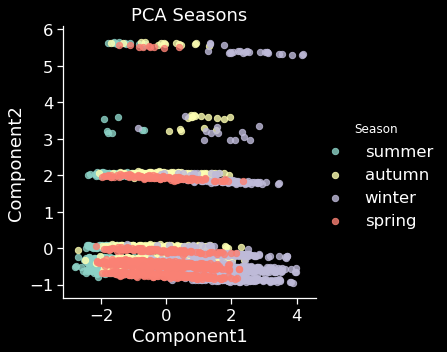

In [814]:
holidays_pca = pd.concat([X_red,pd.DataFrame(df["Season"], columns=["Season"])], axis=1)
holidays_pca.columns = ["Component1", "Component2", "Season"]
grid = sns.FacetGrid(holidays_pca, height=5, hue="Season")
grid.map(plt.scatter, "Component1", "Component2", s=40, alpha=0.8).add_legend()
plt.title("PCA Seasons")
plt.show()

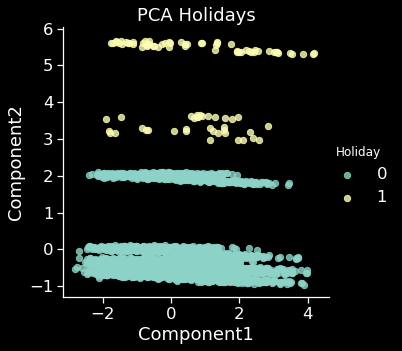

In [815]:
holidays_pca = pd.concat([X_red,pd.DataFrame(df["Holiday"], columns=["Holiday"])], axis=1)
holidays_pca.columns = ["Component1", "Component2", "Holiday"]
grid = sns.FacetGrid(holidays_pca, height=5, hue="Holiday")
grid.map(plt.scatter, "Component1", "Component2", s=40, alpha=0.8).add_legend()
plt.title("PCA Holidays")
#plt.savefig("PCA_holidays.png", dpi=400)
plt.show()

We can see that holidays create a clear cluster, making it an important feature contributing to the variance in our data set

Standarize train and test sets:

In [816]:
scaler_train= StandardScaler().fit(X_train)


X_train_rescaled = scaler_train.transform(X_train)
X_test_rescaled = scaler_train.transform(X_test)

### 6. Exploring model performance

In [902]:
# Exploring model performance. Metrics used neg_mean_squared_error using cross-validation

models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso())) 
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor())) 
models.append(('ETR', ExtraTreesRegressor()))

results_model = []
names_model = []
for name, model in models:
    KF = KFold(n_splits=10, random_state=10)
    cv_results = cross_val_score(model, X_train_rescaled, y_train, cv=KF, scoring='neg_root_mean_squared_error')
    results_model.append(cv_results)
    names_model.append(name)
    msg = "%s: %s (%s)" % (name, round(cv_results.mean(),0), round(cv_results.std(),0))
    print(msg)

LR: -3270699.0 (165600.0)
Lasso: -3270219.0 (167226.0)
EN: -3557574.0 (167748.0)
CART: -2776577.0 (317104.0)
KNN: -2512931.0 (330481.0)
SVR: -5742221.0 (216076.0)
RFR: -2107106.0 (245049.0)
GBR: -2067026.0 (214784.0)
ETR: -2083042.0 (234701.0)


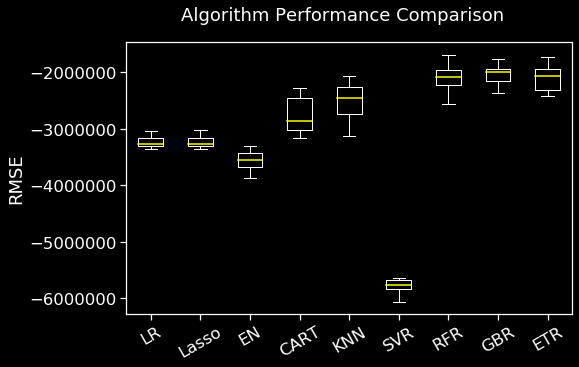

In [903]:
# Compare Algorithms

plt.rcParams["figure.figsize"] = (8,5)
fig = plt.figure()
fig.suptitle('Algorithm Performance Comparison', fontsize=18)
ax = fig.add_subplot(111)

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

plt.boxplot(results_model, boxprops=boxprops,medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, showfliers=True, flierprops=flierprops)
ax.set_xticklabels(names_model, rotation=30)
ax.set_ylabel("RMSE")
#plt.savefig("Algo_comp.png", dpi=400, bbox_inches="tight")


plt.show()

The above analysis revealed **Gradient Boosting Regressor(GBR)** as the most promissing model. Lets fine tune it using GridSearchCV

### 7. Fine Tunning and model evaluation

In [819]:
# GridSearchCV
n_estimators = [70,100,130] # [0, 50, 100, 150, 200]
learning_rate = [0.05] # [0.03, 0.05, 0.3, 1]
max_depth = [8,10]
min_samples_leaf = [5, 11]

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, min_samples_leaf=min_samples_leaf, max_depth=max_depth)


model = GradientBoostingRegressor()
KF = KFold(n_splits=5, random_state=10) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best -1966740.557995 using {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 11, 'n_estimators': 100}

Best: -1954145.842314 using {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 11, 'n_estimators': 130}
-2041447.382472 (155394.357467) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 70}
-2010606.682451 (149125.639102) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 100}
-2005872.779597 (144126.970653) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 130}
-2024155.613120 (137609.248814) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 11, 'n_estimators': 70}
-1966835.558343 (128038.267688) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 11, 'n_estimators': 100}
-1954145.842314 (122451.938369) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 11, 'n_estimators': 130}
-2091524.612187 (160112.207988) with: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 70}
-2066304.089182 (165458.609970) 

In [820]:
GBoost = GradientBoostingRegressor(learning_rate=0.05, n_estimators=120, max_depth=6, min_samples_leaf=14) # adjusting parameters to avoid overfitting
GBoost.fit(X_train_rescaled,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=14, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [821]:
GBoost.score(X_train_rescaled,y_train)

0.9390495777062726

In [822]:
GBoost.score(X_test_rescaled,y_test)

0.9006856942812702

In [823]:
X

prcp  t max  t min  Year  Month  Holiday  Friday  Monday  Saturday  \
0     0.00   25.6   12.8  2010      9        0       0       1         0   
1     0.00   25.0    8.3  2010      9        0       0       0         0   
2     0.00   32.8   16.1  2010      9        0       0       0         0   
3     0.00   31.7   17.8  2010      9        0       0       0         0   
4     0.00   35.0   21.1  2010      9        0       1       0         0   
...    ...    ...    ...   ...    ...      ...     ...     ...       ...   
3375  0.00   14.4    5.0  2019     12        0       1       0         0   
3376  0.00   18.3    1.7  2019     12        0       0       0         1   
3377  0.59    8.9    4.4  2019     12        0       0       0         0   
3378  0.24   16.7    6.1  2019     12        0       0       1         0   
3379  0.00   11.7    5.6  2019     12        0       0       0         0   

      Sunday  Thursday  Tuesday  Wednesday  
0          0         0        0          0  
1          0         0        1          0  
2          0         0        0          1  
3          0         1        0          0  
4          0         0        0          0  
...      ...       ...      ...        ...  
3375       0         0        0          0  
3376       0         0        0          0  
3377       1         0        0          0  
3378       0         0        0          0  
3379       0         0        1          0  

[3380 rows x 13 columns]

** Analyzing Feature importance** to discard noisy features 

In [824]:
feat_imp = pd.Series(GBoost.feature_importances_)
features = pd.Series(X.columns)

In [825]:
feature_importance = pd.concat([features,feat_imp], axis=1, keys=["Feature","Importance"])

In [826]:
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

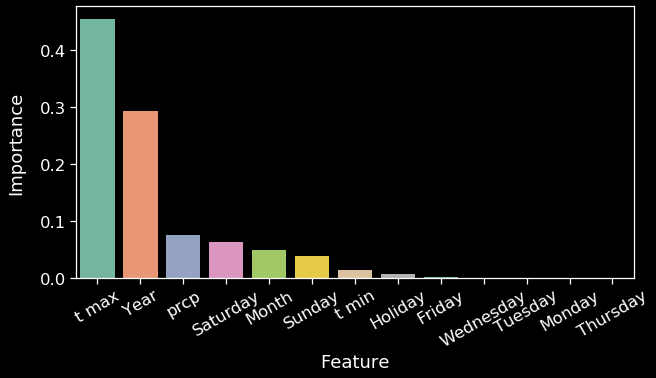

In [827]:
plt.rcParams["figure.figsize"] = (10,5)
imp_pallete = sns.color_palette("Set2")
sns.barplot(x="Feature", y="Importance", data=feature_importance, palette=imp_pallete)
plt.xticks(rotation=30)
plt.ylabel("Importance", labelpad=15)
plt.show()

We see how the laboral week days do not play an important role on the model performace. Hence we could train the model only on the Saturday, Sunday, Holiday information

### 8. Productionazing the model

Important to remember that we used **StandardScaler()** on the data. So we need to use use our train_scaler to transform/standarized the input data prior to doing the predictions

In [828]:
# Defining a function that predicts the total usage time

def predict_total_time(Week_day, Precipitation, T_max, T_min, Year, Month, Holiday):
    
    loc_index = np.where(X.columns==Week_day)[0][0] # X is an np array so we use where method to loc the index
    
    x= np.zeros(len(X.columns))
    x[0] = Precipitation
    x[1] = T_max
    x[2] = T_min
    x[3] = Year
    x[4] = Month
    x[5] = Holiday
    if loc_index >= 0:
        x[loc_index] = 1
    
    x = scaler_train.transform(x.reshape(-1, 1).T)
    
    print(x)
    
    return " ".join((str(round(GBoost.predict(x)[0],0)), "seconds"))   
    

In [829]:
predict_total_time("Monday",0,22, 8, 2015, 4, 0)

[[-0.34586618  0.27667053 -0.02850695  0.05377404 -0.76138067 -0.17005684
  -0.40992018  2.4        -0.4068381  -0.40560245 -0.40560245 -0.40745532
  -0.40560245]]


'12951349.0 seconds'

In [830]:
str(dt.timedelta(seconds=12141177.0))

'140 days, 12:32:57'

In [831]:
import pickle
with open ("total_bike_time.pickle", "wb") as f:
    pickle.dump(GBoost,f)

In [832]:
import json
columns = {"data_columns":[col.lower() for col in X.columns]}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

In [833]:
from pickle import load
with open("total_bike_time.pickle", 'rb') as pickle_file:
    model = pickle.load(pickle_file)

### Lets repeat the process to predict number of trips

First I will remove the feature that seemed not to pley a large role in the model performance

In [834]:
df_model.drop(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], axis=1, inplace=True)

### 4.2 Data Split

We want that after our split we obtian a balanced distribution of the target values accorss the data. Hence, we first need to see whether if our target **normaly distributed** or **skewed**? We will start predicting the Total Usage. We observe that the data is skewed to the right. Hence, stratifying the data set is adviced for the splitting.

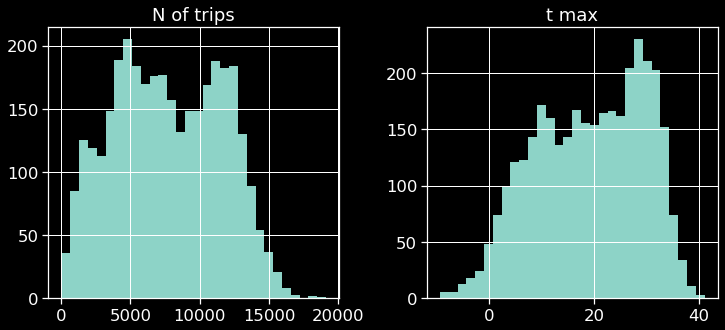

In [835]:
plt.rcParams["figure.figsize"] = (12,5)
df_model[['N of trips','t max']].hist(bins=30)
plt.show()

Lets stratify the split based on the stratification of t max in 5 different strata.

In [836]:
df_model["strat"] = df_model["t max"].apply(strater)

In [837]:
X2 = df_model.drop(['Total usage(s)','N of trips'], axis=1)
y = df_model['N of trips'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.20, random_state=10)

In [838]:
test_set = X_test2

In [839]:
test_set["strat"] = X_test2["t max"].apply(strater)

In [840]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=10)

In [841]:
for train_index, test_index in split.split(df_model, df_model["strat"]):
    strat_train_set = df_model.loc[train_index]
    strat_test_set = df_model.loc[test_index]

In [842]:
def proportions(data):
    return data["strat"].value_counts()/len(data)

In [843]:
comparing = pd.DataFrame({"Overall": proportions(df_model),
                         "Stratified": proportions(strat_test_set),
                         "Random": proportions(X_test2)}).sort_index()

In [844]:
comparing = round(comparing *100,2) 

In [845]:
comparing 
# N of Trips was closer so a normal distributions, this is why the random split bring similar results when compared to the stratified split.

Overall  Stratified  Random
1    10.80       10.80   10.21
2    17.69       17.60   17.31
3    30.41       30.47   29.44
4    24.88       24.85   25.59
5    16.21       16.27   17.46

In [846]:
strat_train_set.drop("strat", axis=1, inplace=True)
strat_test_set.drop("strat", axis=1, inplace=True)

In [847]:
X_train2 = strat_train_set.drop(["Total usage(s)","N of trips"], axis=1)
y_train2 = strat_train_set["N of trips"].values

In [848]:
X_test2 = strat_test_set.drop(["Total usage(s)","N of trips"], axis=1)
y_test2 = strat_test_set["N of trips"].values

In [849]:
df_model.drop("strat", axis=1, inplace=True)
X2.drop("strat", axis=1, inplace=True)

### 5.2 Standarize train and test sets:

In [850]:
scaler_train2= StandardScaler().fit(X_train2)

X_train_rescaled2 = scaler_train2.transform(X_train2)
X_test_rescaled2 = scaler_train2.transform(X_test2)

### 6.2. Exploring model performance

In [901]:
# Exploring model performance. Metrics used neg_mean_squared_error using cross-validation

models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso())) 
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RFR', RandomForestRegressor()))
models.append(('XGB', xgb.XGBRegressor(objective='reg:squarederror')))
models.append(('ETR', ExtraTreesRegressor()))

results_model = []
names_model = []
for name, model in models:
    KF = KFold(n_splits=10, random_state=10)
    cv_results = cross_val_score(model, X_train_rescaled2, y_train2, cv=KF, scoring='neg_root_mean_squared_error')
    results_model.append(cv_results)
    names_model.append(name)
    msg = "%s: %s (%s)" % (name, round(cv_results.mean(),0), round(cv_results.std(),0))
    print(msg)

LR: -2045.0 (78.0)
Lasso: -2045.0 (78.0)
EN: -2271.0 (62.0)
CART: -1629.0 (156.0)
KNN: -1420.0 (94.0)
SVR: -3744.0 (80.0)
RFR: -1201.0 (113.0)
XGB: -1181.0 (105.0)
ETR: -1189.0 (94.0)


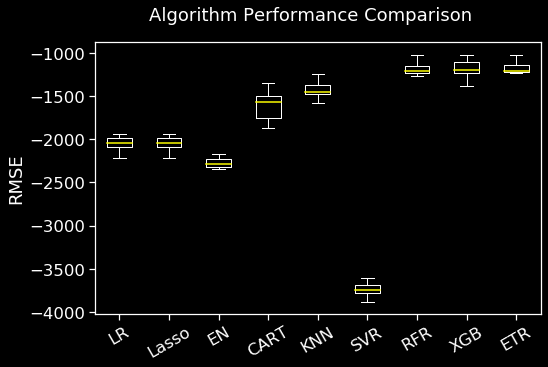

In [900]:
# Compare Algorithms

plt.rcParams["figure.figsize"] = (8,5)
fig = plt.figure()
fig.suptitle('Algorithm Performance Comparison', fontsize=18)
ax = fig.add_subplot(111)

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

plt.boxplot(results_model, boxprops=boxprops,medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, showfliers=True, flierprops=flierprops)
ax.set_xticklabels(names_model, rotation=30)
ax.set_ylabel("RMSE")
#plt.savefig("Algo_comp1.png", dpi=400, bbox_inches="tight")


plt.show()

The above analysis revealed **Gradient Boosting Regressor(GBR)** as the most promissing model. Lets fine tune it using GridSearchCV

### 7.2. Fine Tunning and model evaluation

In [853]:
# GridSearchCV
n_estimators = [25, 50, 70] 
max_depth = [4, 8, 10]
min_samples_leaf = [2, 5, 11]

param_grid = dict(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth)


model = ExtraTreesRegressor()
KF = KFold(n_splits=5, random_state=10) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train2, y_train2)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best -1237.545910 using {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50}

Best: -1242.027263 using {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 70}
-1760.398772 (31.565079) with: {'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 25}
-1750.091777 (58.226209) with: {'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 50}
-1768.977656 (46.306503) with: {'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 70}
-1766.487541 (43.427710) with: {'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 25}
-1768.845007 (54.867347) with: {'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 50}
-1755.359513 (50.214734) with: {'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 70}
-1766.336355 (37.534733) with: {'max_depth': 4, 'min_samples_leaf': 11, 'n_estimators': 25}
-1752.250549 (60.434126) with: {'max_depth': 4, 'min_samples_leaf': 11, 'n_estimators': 50}
-1753.831164 (53.550458) with: {'max_depth': 4, 'min_samples_leaf': 11, 'n_estimators': 70}
-1322.922231 (55.510192) with: {'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 25}
-

In [854]:
EtReg = ExtraTreesRegressor(n_estimators=50, max_depth=10, min_samples_leaf=2) # 
EtReg.fit(X_train_rescaled2,y_train2)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=10, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=50, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [855]:
EtReg.score(X_train_rescaled2,y_train2) 

0.9411825935523784

In [856]:
EtReg.score(X_test_rescaled2,y_test2) 

0.9011612303632432

**Feature importance**

In [857]:
feat_imp = pd.Series(EtReg.feature_importances_)
features = pd.Series(X2.columns)

In [858]:
feature_importance = pd.concat([features,feat_imp], axis=1, keys=["Feature","Importance"])

In [859]:
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

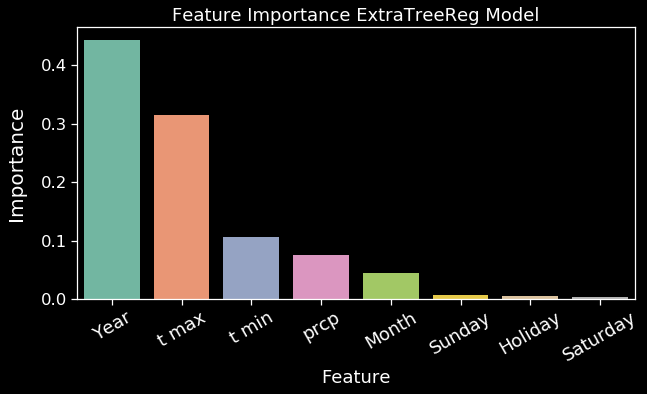

In [899]:
plt.rcParams["figure.figsize"] = (10,5)
imp_pallete = sns.color_palette("Set2")
sns.barplot(x="Feature", y="Importance", data=feature_importance, palette=imp_pallete)
plt.xticks(rotation=30, fontsize=18)
plt.ylabel("Importance", labelpad=15, fontsize=20)
plt.title("Feature Importance ExtraTreeReg Model")
#plt.savefig("Feature_importance.png", dpi=400, bbox_inches="tight")
plt.show()

### 8.2 Productionazing the model

In [861]:
# Defining a function that predicts the total usage time

def predict_N_trips(Week_day, Precipitation, T_max, T_min, Year, Month, Holiday):
    
    
    
    x= np.zeros(len(X2.columns))
    x[0] = Precipitation
    x[1] = T_max
    x[2] = T_min
    x[3] = Year
    x[4] = Month
    x[5] = Holiday
    
    try:
        loc_index = np.where(X2.columns==Week_day)[0][0] # X is an np array so we use where method to loc the index
        if loc_index >= 0:
            x[loc_index] = 1

    except IndexError:
        pass
    
    x = scaler_train2.transform(x.reshape(-1, 1).T)
    
    return " ".join((str(round(EtReg.predict(x)[0],0)), "trips"))   
    

In [862]:
predict_N_trips("Sunday",0,30, 4, 2019, 5, 1)

'11446.0 trips'

In [863]:
time_per_trip = 9202895/9205.0 # in seconds

In [864]:
str(dt.timedelta(seconds=time_per_trip)) # The average time usage for that particular day would be 16-17 mins

'0:16:39.771320'

In [865]:
import pickle
with open ("N_bike_trips.pickle", "wb") as f:
    pickle.dump(EtReg,f)

In [866]:
import json
columns = {"data_columns":[col.lower() for col in X.columns]}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

In [867]:
from pickle import load
with open("N_bike_trips.pickle", 'rb') as pickle_file:
    model = pickle.load(pickle_file)